In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
#read data from csv
df = pd.read_csv('Medicoes_de_Campos_Eletromagneticos_2016-2020.csv', sep = ';')
df.head(3)

<ipython-input-2-e292f12b20ab>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Medicoes_de_Campos_Eletromagneticos_2016-2020.csv', sep = ';')


,Responsável,Nome Responsável,Data da Medicao,Hora da Medicao,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação
0,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,"-30,046873","-51,206071",Porto Alegre,RS,"0,27","0,01%",N/I,NaN
1,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,"-30,046873","-51,206071",Porto Alegre,RS,"0,4","0,02%",N/I,NaN
2,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,"-27,59764","-48,54856",Florianópolis,SC,"0,48","0,03%",N/I,NaN


In [3]:
#handling dataframe column dtypes
df['Latitude'] = df['Latitude'].str.replace(',','.')
df['Longitude'] = df['Longitude'].str.replace(',','.')
df['Valor Medio'] = df['Valor Medio'].str.replace(',','.')
df['% do Limite'] = df['% do Limite'].str.replace(',','.')
df['% do Limite'] = df['% do Limite'].str.replace('%','')

#assigning new types for each column
df = df.astype({
    'Responsável': 'category', 
    'Nome Responsável': 'category',
    'Data da Medicao': 'str',
    'Hora da Medicao': 'str',
    'Tipo de Medicao': 'category',
    'Latitude': 'float16',
    'Longitude': 'float16',
    'Municipio': 'category',
    'UF': 'category',
    'Valor Medio': 'float16',
    '% do Limite': 'float16',
    'Número Estação': 'category',
    'Operadora da Estação': 'category',
})

#merging columns indicating date and time to make one Time column of tipe datetime
df.insert(3,'Time',df['Data da Medicao'] + ' ' + df['Hora da Medicao'])
df['Time'] = pd.to_datetime(df['Time'], format = '%d/%m/%Y %H:%M:%S')
df.drop(['Data da Medicao', 'Hora da Medicao'], axis = 1, inplace = True)

df.head()

,Responsável,Nome Responsável,Time,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação
0,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-30.046875,-51.21875,Porto Alegre,RS,0.270020,0.010002,N/I,NaN
1,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-30.046875,-51.21875,Porto Alegre,RS,0.399902,0.020004,N/I,NaN
2,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-27.593750,-48.56250,Florianópolis,SC,0.479980,0.029999,N/I,NaN
3,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-25.437500,-49.28125,Curitiba,PR,1.759766,0.399902,N/I,NaN
4,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-20.453125,-54.59375,Campo Grande,MS,0.219971,0.010002,N/I,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642584 entries, 0 to 642583
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Responsável           642584 non-null  category      
 1   Nome Responsável      642584 non-null  category      
 2   Time                  642584 non-null  datetime64[ns]
 3   Tipo de Medicao       642584 non-null  category      
 4   Latitude              642584 non-null  float16       
 5   Longitude             642584 non-null  float16       
 6   Municipio             642584 non-null  category      
 7   UF                    642584 non-null  category      
 8   Valor Medio           642584 non-null  float16       
 9   % do Limite           642584 non-null  float16       
 10  Número Estação        642584 non-null  category      
 11  Operadora da Estação  179036 non-null  category      
dtypes: category(7), datetime64[ns](1), float16(4)
memory usage

In [5]:
#some basic information about the dataset
print(f'Total de empresas responsáveis: {len(df["Nome Responsável"].unique())}')
print(f'Tipos de medição: {len(df["Tipo de Medicao"].unique())}')
print(f'Total de Municípios Distintos: {len(df["Municipio"].unique())}')
print(f'Total de Unidades da Federação: {len(df["UF"].unique())}')

Total de empresas responsáveis: 11
Tipos de medição: 3
Total de Municípios Distintos: 4153
Total de Unidades da Federação: 27


In [6]:
# def plot_kmeans(k,df,xcol,ycol):
#     #application of kmeans
#     X = df[[xcol,ycol]]
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(X)
#     predictions = kmeans.predict(X)

#     #comparing kmeans result to plotting grouping by labelling variable
#     fig, axs = plt.subplots(1,1, figsize=(15,4))

#     scatter = axs.scatter(X[xcol], X[ycol], c = predictions, label = predictions)
#     axs.set_title('KMeans')
#     legend1 = axs.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
#     axs.add_artist(legend1)
#     axs.set_xlabel(xcol)
#     axs.set_ylabel(ycol)
    
# plot_kmeans(5, df, 'Latitude', 'Longitude')

In [7]:
# fdf = df[(df['UF'] == 'DF')]
fdf = df
latmin = min(fdf['Latitude'])
latmax = max(fdf['Latitude'])
longmin = min(fdf['Longitude'])
longmax = max(fdf['Longitude'])
print(f'latmin: {latmin}\nlatmax: {latmax}\nlongmin: {longmin}\nlongmax: {longmax}\n')
fdf.head()

latmin: -33.6875
latmax: 3.841796875
longmin: -72.9375
longmax: -32.40625



,Responsável,Nome Responsável,Time,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação
0,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-30.046875,-51.21875,Porto Alegre,RS,0.270020,0.010002,N/I,NaN
1,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-30.046875,-51.21875,Porto Alegre,RS,0.399902,0.020004,N/I,NaN
2,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-27.593750,-48.56250,Florianópolis,SC,0.479980,0.029999,N/I,NaN
3,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-25.437500,-49.28125,Curitiba,PR,1.759766,0.399902,N/I,NaN
4,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-20.453125,-54.59375,Campo Grande,MS,0.219971,0.010002,N/I,NaN


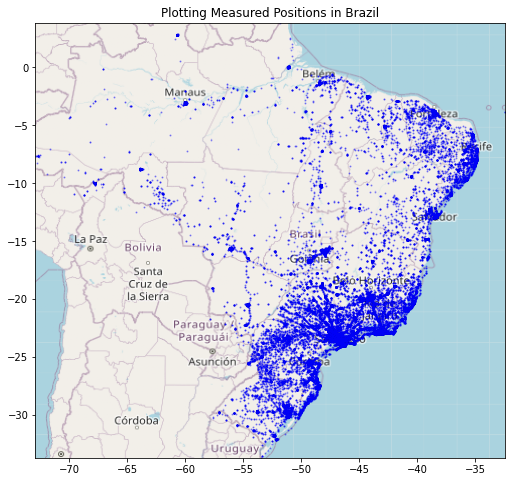

In [8]:
BBox = ((longmin, longmax, latmin, latmax))
brasil = plt.imread('brasil.png')
fig, ax = plt.subplots(figsize = (16,8))
ax.scatter(fdf.Longitude, fdf.Latitude, zorder=1, alpha= 0.1, c='b', s=1)
ax.set_title('Plotting Measured Positions in Brazil')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(brasil, zorder=0, extent = BBox, aspect= 'equal')

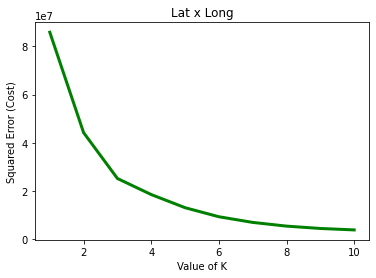

In [9]:
def elbow_method(X,title):
    cost =[]
    for i in range(1, 11):
        KM = KMeans(n_clusters = i, max_iter = 500)
        KM.fit(X)

        # calculates squared error
        # for the clustered points
        cost.append(KM.inertia_)    

    # plot the cost against K values
    plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
    plt.title(title)
    plt.xlabel("Value of K")
    plt.ylabel("Squared Error (Cost)")
    plt.show() # clear the plot
    
elbow_method(df[['Latitude','Longitude']], 'Lat x Long')

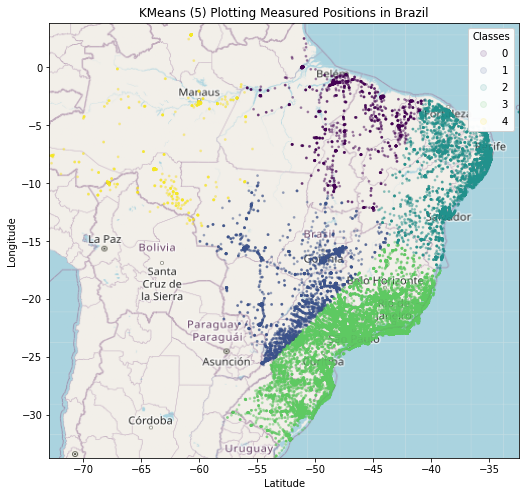

In [10]:
def plot_kmeans(k,df,xcol,ycol):
    #application of kmeans
    X = df[[xcol,ycol]]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    predictions = kmeans.predict(X)
    
    BBox = ((longmin, longmax, latmin, latmax))
    brasil = plt.imread('brasil.png')
    
    fig, axs = plt.subplots(1,1,figsize = (16,8))
    scatter = axs.scatter(df.Longitude, df.Latitude, zorder=1, alpha= 0.1, c=predictions, s=3)
    axs.set_title(f'KMeans ({k}) Plotting Measured Positions in Brazil')
    axs.set_xlim(BBox[0],BBox[1])
    axs.set_ylim(BBox[2],BBox[3])
    legend1 = axs.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    axs.add_artist(legend1)
    axs.set_xlabel(xcol)
    axs.set_ylabel(ycol)
    axs.imshow(brasil, zorder=0, extent = BBox, aspect= 'equal')
    
plot_kmeans(5, df, 'Latitude', 'Longitude')

In [11]:
#separation features and target
fdf = df[(df['UF'] == 'GO') & (df['Municipio'] == 'Anápolis')]
X = fdf[['Latitude', 'Longitude']]
y = fdf['Valor Medio']

modelos = []
modelos.append(('LR', LinearRegression()))
modelos.append(('RDG', Ridge()))
modelos.append(('LSS', Lasso()))
modelos.append(('DTR', DecisionTreeRegressor()))
# modelos.append(('KNNR', KNeighborsRegressor()))
# modelos.append(('SVR', SVR()))

for modelo in modelos:
    nome = modelo[0]
    modelo_aplicado = modelo[1]
    
    kfold = KFold(n_splits=3)
    resultados = cross_val_score(modelo_aplicado, np.array(X),np.array(y), cv=kfold, scoring='r2')
    print(f'Índice escolhido com média de {nome}: {resultados.mean()}')

Índice escolhido com média de LR: -0.29786342357277784
Índice escolhido com média de RDG: -0.25992548646135255
Índice escolhido com média de LSS: -0.2752270055231945
Índice escolhido com média de DTR: -0.5744461490521909
